# Trading Bot
This notebook is based on the tools developed in [Financial Reinforcement Learning (FinRL) repo](https://github.com/AI4Finance-Foundation/FinRL/tree/master). The notebook recreates the neccesary steps to fetch financial data from the Dow 30 stocks list, preprocess the data, set models environment and train the model.

**Still need to work on:**
- Integration with alpaca API
- Run dummy trades

### 1. Import Libraries and Dependencies

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

### 2. Create Folders

In [3]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

### 3. Download Data

In [4]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [5]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2023-01-01'
TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-02-25'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (109992, 8)


In [6]:
# EDA 1
df.sort_values(['date','tic'])

,date,open,high,low,close,volume,tic,day
0,2009-04-01,3.717500,3.892857,3.710357,3.286318,589372000,AAPL,2
1,2009-04-01,48.779999,48.930000,47.099998,34.743195,10850100,AMGN,2
2,2009-04-01,13.340000,14.640000,13.080000,11.528121,27701800,AXP,2
3,2009-04-01,34.520000,35.599998,34.209999,26.850744,9288800,BA,2
4,2009-04-01,27.500000,29.520000,27.440001,19.262983,15308300,CAT,2
...,...,...,...,...,...,...,...,...
109987,2024-02-23,526.750000,530.500000,524.159973,525.169739,2502000,UNH,4
109988,2024-02-23,284.720001,285.950012,283.500000,283.600006,5107700,V,4
109989,2024-02-23,40.630001,41.150002,40.459999,40.012051,15228600,VZ,4
109990,2024-02-23,21.500000,21.930000,21.410000,21.730000,31886700,WBA,4


In [7]:
# EDA
df.tic.value_counts()

tic
AAPL    3750
AMGN    3750
WMT     3750
WBA     3750
VZ      3750
V       3750
UNH     3750
TRV     3750
PG      3750
NKE     3750
MSFT    3750
MRK     3750
MMM     3750
MCD     3750
KO      3750
JPM     3750
JNJ     3750
INTC    3750
IBM     3750
HON     3750
HD      3750
GS      3750
DIS     3750
CVX     3750
CSCO    3750
CRM     3750
CAT     3750
BA      3750
AXP     3750
DOW     1242
Name: count, dtype: int64

### 4. Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: **MACD and RSI**.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.,

In [10]:
INDICATORS = ['macd',
               'rsi_30',
               'cci_30',
               'dx_30']

In [11]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [12]:
processed.sample(10)

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
59005,2017-05-01,59.398853,59.637405,59.255726,48.125050,10707521,MRK,0,-0.272186,46.458028,-90.872029,18.666422,19.863319
7906,2010-04-30,74.163879,75.000000,73.913040,43.957096,6293352,MMM,4,0.796562,63.967272,174.328907,54.405959,44.907033
6448,2010-02-18,30.020000,30.379999,29.870001,21.590359,16564800,HD,3,0.261040,60.851700,231.971940,38.933970,0.000000
99581,2022-11-17,512.159973,526.979980,512.159973,504.119568,4246300,UNH,3,-2.639855,47.141082,-45.403649,18.883926,34.400735
16529,2011-07-05,17.780001,17.853333,17.673332,13.472543,27637500,WMT,1,-0.060565,49.342827,-17.929087,7.717859,18.242727
55868,2016-11-22,114.589996,115.000000,112.269997,92.736961,11649700,JNJ,1,-0.281985,41.890514,-121.280086,19.580257,49.168237
59734,2017-06-06,125.190002,125.449997,124.019997,105.567223,1277700,TRV,1,0.923324,57.645542,127.598470,29.246812,26.417310
90213,2021-08-09,152.889999,153.910004,152.080002,144.482178,680000,TRV,0,-0.174844,51.955280,82.776129,3.579218,6.878043
31052,2013-07-02,77.949997,78.610001,77.709999,57.209442,10228500,PG,1,-0.134894,51.725217,10.568353,8.018474,34.914971
69229,2018-09-24,48.209999,48.619999,48.189999,40.692741,21819300,CSCO,0,0.641213,65.102032,130.006125,43.627009,34.292250


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [13]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [14]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

## Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [15]:
rebalance_window = 63 #63 # rebalance_window is the number of days to retrain the model
validation_window = 63 #63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [16]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2, #2048
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 1, #10_000
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 1, #10_000 each
                 'ppo' : 1, 
                 'ddpg' : 1
                 }

In [17]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  201.74268936810594
======Model training from:  2009-04-01 to  2023-01-03
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_4
======A2C Validation from:  2023-01-03 to  2023-04-04
A2C Sharpe Ratio:  0.011585298403872695
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ppo_126_4
-----------------------------------
| time/              |            |
|    fps             | 42         |
|    iterations      | 1          |
|    time_elapsed    | 0          |
|    total_timesteps | 2          |
| train/             |            |
|    reward          | 0.04405863 |
-----------------------------------
======PPO Validation from:  2023-01-03 to  2023-04-04
PPO Sharpe Ratio:  0.036029889318684186
======DDPG Training========
{'buffer_

In [16]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2023-01-03,2023-04-04,A2C,0.152884,0.049196,0.03765
1,189,2023-04-04,2023-07-06,DDPG,0.146141,0.105265,0.296693
2,252,2023-07-06,2023-10-04,DDPG,-0.352225,-0.394244,0.165127


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [18]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [19]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  2.124317936055955


<Axes: >

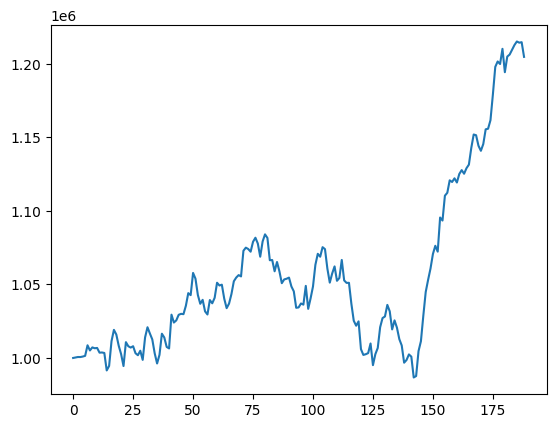

In [20]:
%matplotlib inline
df_account_value.account_value.plot()

In [21]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.281573
Cumulative returns     0.204502
Annual volatility      0.120878
Sharpe ratio           2.124318
Calmar ratio           3.139600
Stability              0.492929
Max drawdown          -0.089684
Omega ratio            1.421699
Sortino ratio          3.467347
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.296563
Daily value at risk   -0.014210
dtype: float64


In [22]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

[*********************100%%**********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (188, 8)
Annual return          0.176766
Cumulative returns     0.129112
Annual volatility      0.102214
Sharpe ratio           1.652210
Calmar ratio           1.960202
Stability              0.324979
Max drawdown          -0.090178
Omega ratio            1.309241
Sortino ratio          2.659878
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.197511
Daily value at risk   -0.012208
dtype: float64


In [23]:
df_account_value

,account_value,date,daily_return,datadate
0,1.000000e+06,2023-04-04,NaN,2023-04-04
1,1.000330e+06,2023-04-05,0.000330,2023-04-05
2,1.000651e+06,2023-04-06,0.000321,2023-04-06
3,1.000624e+06,2023-04-10,-0.000027,2023-04-10
4,1.000946e+06,2023-04-11,0.000322,2023-04-11
...,...,...,...,...
184,1.212546e+06,2023-12-27,0.002694,2023-12-27
185,1.214966e+06,2023-12-28,0.001996,2023-12-28
186,1.214148e+06,2023-12-29,-0.000673,2023-12-29
187,1.214487e+06,2024-01-02,0.000279,2024-01-02


In [24]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = '^DJI', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

[*********************100%%**********************]  1 of 1 completed

==============Compare to DJIA===========
Shape of DataFrame:  (188, 8)


AttributeError: 'Series' object has no attribute 'iteritems'

In [25]:
print(df_account_value.head())
print(df_account_value.dtypes)

   account_value        date  daily_return    datadate
0   1.000000e+06  2023-04-04           NaN  2023-04-04
1   1.000330e+06  2023-04-05      0.000330  2023-04-05
2   1.000651e+06  2023-04-06      0.000321  2023-04-06
3   1.000624e+06  2023-04-10     -0.000027  2023-04-10
4   1.000946e+06  2023-04-11      0.000322  2023-04-11
account_value    float64
date              object
daily_return     float64
datadate          object
dtype: object
